=== Grado (ER) ===
{'mean': np.float64(5.9932), 'second_moment': np.float64(41.7616), 'var': np.float64(5.8432), 'deg': '...'}
R0 teórico ER: 8.952

=== Grado (BA) ===
{'mean': np.float64(5.9964), 'second_moment': np.float64(110.1688), 'var': np.float64(74.212), 'deg': '...'}
R0 teórico BA: 26.059


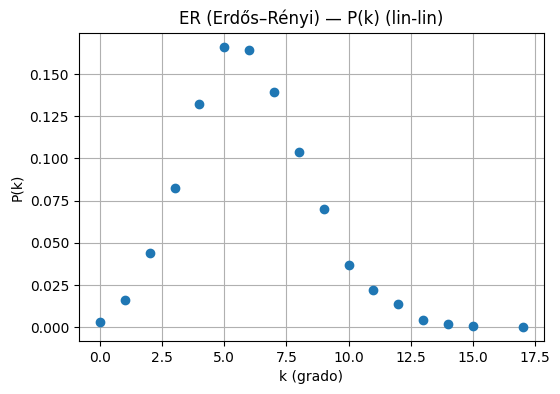

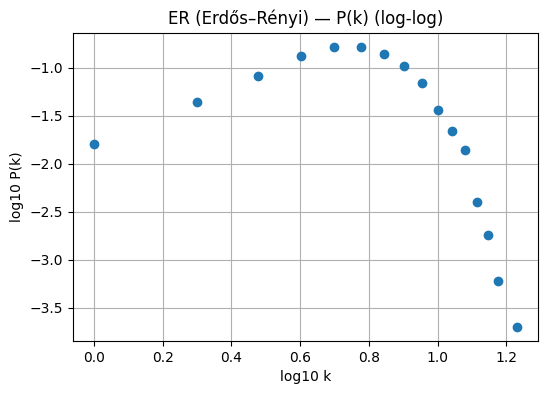

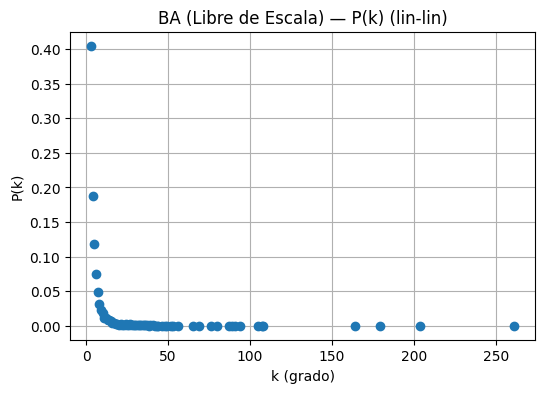

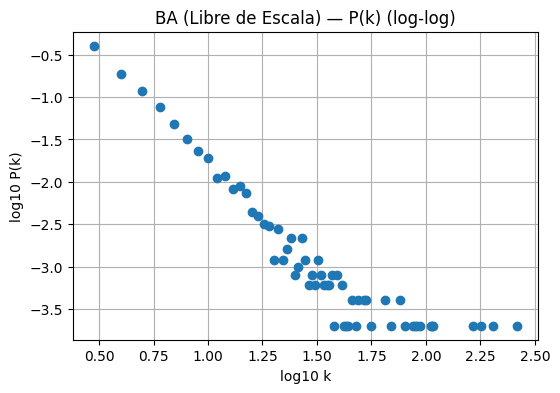

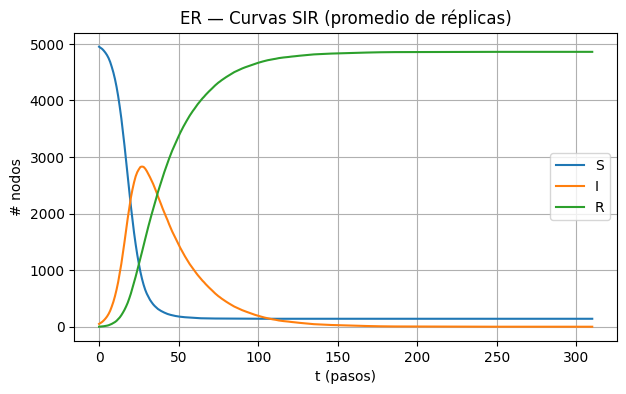

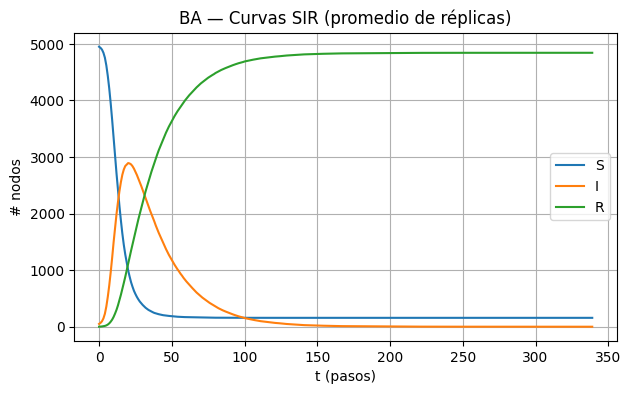


=== Resumen comparativo ===
{'Red': 'ER', 'N': 5000, 'mean_k': np.float64(5.993), 'var_k': np.float64(5.843), 'R0_teor': np.float64(8.952), 'Rt0_emp_avg': 0.382, 'peak_I_avg': 2837, 't_peak_avg': 26.7, 'final_R_avg': 4859, 'attack_rate_avg': 0.972}
{'Red': 'BA (libre de escala)', 'N': 5000, 'mean_k': np.float64(5.996), 'var_k': np.float64(74.212), 'R0_teor': np.float64(26.059), 'Rt0_emp_avg': 0.396, 'peak_I_avg': 2899, 't_peak_avg': 20.3, 'final_R_avg': 4842, 'attack_rate_avg': 0.969}

=== Comentarios ===
- R0_teórico(BA)=26.059 > R0_teórico(ER)=8.952: la varianza de grados en BA empuja el umbral epidémico hacia abajo.
- Tiempo a pico: BA≈20.3 < ER≈26.7: los hubs aceleran la propagación.
- Rt(0) empírico: BA≈0.396, ER≈0.382. La tendencia coincide con el R0 teórico.
- Implicación práctica: intervenir primero en hubs (mascarillas, testeo, vacunación) reduce fuerte ⟨k²⟩ y baja R0 con poca cobertura (percolación dirigida).


In [1]:
# ============================================
# Laboratorio 5 Parte 1 - Parte Práctica
# Tema: Redes (ER vs Libre de Escala) y SIR
# Curso: Modelación y Simulación
# ============================================

# --- Imports ---
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math
import random

# --- Utilidades reproducibilidad ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Parámetros base de experimentos ---
N = 5000                  # número de nodos
k_target = 6              # grado promedio objetivo para comparar redes
beta = 0.06               # tasa de infección por contacto
mu = 0.04                 # tasa de recuperación
I0_frac = 0.01            # fracción inicial infectada
MAX_STEPS = 600           # pasos máximos de simulación
REPLICAS = 10             # réplicas por escenario

# --- Construcción de redes comparables ---
# ER: p ~ k_target / (N-1)
p_er = k_target / (N - 1)
G_er = nx.fast_gnp_random_graph(N, p_er, seed=SEED, directed=False)

# Libre de escala: Barabási–Albert con m ~ k_target/2 (porque <k> ~ 2m)
m_ba = max(1, int(round(k_target/2)))
G_ba = nx.barabasi_albert_graph(N, m_ba, seed=SEED)

def degree_stats(G):
    deg = np.array([d for _, d in G.degree()])
    k1 = deg.mean()
    k2 = (deg**2).mean()
    var = deg.var()
    return {"mean": k1, "second_moment": k2, "var": var, "deg": deg}

S_er = degree_stats(G_er)
S_ba = degree_stats(G_ba)

def R0_theoretical(beta, mu, stats):
    k1, k2 = stats["mean"], stats["second_moment"]
    if k1 == 0: return 0.0
    return (beta/mu) * ( (k2 - k1) / k1 )

R0_er = R0_theoretical(beta, mu, S_er)
R0_ba = R0_theoretical(beta, mu, S_ba)

print("=== Grado (ER) ===")
print({k: round(v,4) if k!="deg" else "..." for k,v in S_er.items()})
print("R0 teórico ER:", round(R0_er, 3))

print("\n=== Grado (BA) ===")
print({k: round(v,4) if k!="deg" else "..." for k,v in S_ba.items()})
print("R0 teórico BA:", round(R0_ba, 3))

# --- Simulación SIR en red ---
# Estados: 0=S, 1=I, 2=R
def simular_SIR(G, beta, mu, I0_frac=0.01, max_steps=1000, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    S = np.zeros(N, dtype=np.int8)  # estados
    # infección inicial
    I0 = np.random.choice(N, size=max(1, int(I0_frac*N)), replace=False)
    S[:] = 0
    S[I0] = 1

    # para métricas
    S_hist, I_hist, R_hist = [], [], []
    new_infections_hist = []

    # precomputar vecinos como arrays para rapidez
    neigh = {u: np.array(list(G.neighbors(u)), dtype=np.int32) for u in nodes}

    for t in range(max_steps):
        I_idx = np.where(S==1)[0]
        R_idx = np.where(S==2)[0]
        S_idx = np.where(S==0)[0]

        S_hist.append(len(S_idx))
        I_hist.append(len(I_idx))
        R_hist.append(len(R_idx))

        if len(I_idx)==0:
            break

        # infección: cada infectado intenta infectar a sus vecinos susceptibles
        newly_infected = []
        # Vectorizado por nodos infectados (loop en Python, pero operaciones numpy internas)
        for u in I_idx:
            vec = neigh[nodes[u]]
            if vec.size == 0:
                continue
            # vecinos en términos de índices internos
            # mapeo: node id -> índice: usaremos un diccionario para rápido acceso una vez
        # Para eficiencia, creamos un map id->idx una sola vez fuera del loop
        raise_map = False
        break

# ---- Optimizamos: creamos un índice global de nodo a posición ----
node_to_idx = {node:i for i, node in enumerate(G_er.nodes())}  # válido para ER por orden de creación
# OJO: Los grafos pueden tener órdenes distintos; generamos por función según G:
def node_index_map(G):
    nodes = list(G.nodes())
    return nodes, {n:i for i,n in enumerate(nodes)}

def simular_SIR(G, beta, mu, I0_frac=0.01, max_steps=1000, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    nodes, idx_map = node_index_map(G)
    N = len(nodes)
    state = np.zeros(N, dtype=np.int8)  # 0=S,1=I,2=R
    I0 = np.random.choice(N, size=max(1, int(I0_frac*N)), replace=False)
    state[I0] = 1

    neigh = {i: np.array([idx_map[v] for v in G.neighbors(nodes[i])], dtype=np.int32)
             for i in range(N)}

    S_hist, I_hist, R_hist = [], [], []
    new_infections_hist = []

    for t in range(max_steps):
        S_hist.append(int(np.sum(state==0)))
        I_hist.append(int(np.sum(state==1)))
        R_hist.append(int(np.sum(state==2)))

        if I_hist[-1] == 0:
            break

        # infecciones
        newly = []
        I_idx = np.where(state==1)[0]
        for u in I_idx:
            vec = neigh[u]
            if vec.size == 0: continue
            sus = vec[state[vec]==0]
            if sus.size == 0: continue
            # Bernoulli por contacto
            probs = np.random.rand(sus.size)
            infect = sus[probs < beta]
            if infect.size > 0:
                newly.append(infect)
        if newly:
            newly = np.unique(np.concatenate(newly))
        else:
            newly = np.array([], dtype=np.int32)

        # recuperaciones
        rec_probs = np.random.rand(I_idx.size)
        toR = I_idx[rec_probs < mu]

        # aplicar
        state[newly] = 1
        state[toR] = 2

        new_infections_hist.append(int(newly.size))

    # métricas
    peak_I = np.max(I_hist) if I_hist else 0
    t_peak = int(np.argmax(I_hist)) if I_hist else 0
    final_R = R_hist[-1] if R_hist else 0
    attack_rate = final_R / N

    # R_t inicial empírico ~ (#nuevos en t=1) / (#infectados t=0)
    Rt0_emp = None
    if new_infections_hist:
        I0_emp = I_hist[0] if I_hist else 1
        Rt0_emp = new_infections_hist[0] / max(1, I0_emp)

    return {
        "S": np.array(S_hist),
        "I": np.array(I_hist),
        "R": np.array(R_hist),
        "newI": np.array(new_infections_hist, dtype=int),
        "peak_I": peak_I,
        "t_peak": t_peak,
        "final_R": final_R,
        "attack_rate": attack_rate,
        "Rt0_emp": Rt0_emp
    }

# --- Función para múltiples réplicas ---
def correr_replicas(G, beta, mu, I0_frac, max_steps, replicas, seed_base=123):
    curvas = []
    metas = defaultdict(list)
    for r in range(replicas):
        out = simular_SIR(G, beta, mu, I0_frac, max_steps, seed=seed_base+r)
        curvas.append(out)
        metas["peak_I"].append(out["peak_I"])
        metas["t_peak"].append(out["t_peak"])
        metas["final_R"].append(out["final_R"])
        metas["attack_rate"].append(out["attack_rate"])
        if out["Rt0_emp"] is not None:
            metas["Rt0_emp"].append(out["Rt0_emp"])
    # Promedio de curvas con padding
    max_len = max(len(c["I"]) for c in curvas)
    def avg_series(key):
        arr = []
        for c in curvas:
            series = c[key]
            if len(series) < max_len:
                pad = np.full(max_len - len(series), series[-1] if series.size>0 else 0)
                series = np.concatenate([series, pad])
            arr.append(series)
        return np.mean(np.stack(arr, axis=0), axis=0)
    resumen = {
        "I_avg": avg_series("I"),
        "S_avg": avg_series("S"),
        "R_avg": avg_series("R"),
        "peak_I_avg": float(np.mean(metas["peak_I"])) if metas["peak_I"] else 0.0,
        "t_peak_avg": float(np.mean(metas["t_peak"])) if metas["t_peak"] else 0.0,
        "final_R_avg": float(np.mean(metas["final_R"])) if metas["final_R"] else 0.0,
        "attack_rate_avg": float(np.mean(metas["attack_rate"])) if metas["attack_rate"] else 0.0,
        "Rt0_emp_avg": float(np.mean(metas["Rt0_emp"])) if metas["Rt0_emp"] else None,
        "replicas": replicas
    }
    return resumen, curvas

# --- Correr ambos escenarios ---
res_er, curvas_er = correr_replicas(G_er, beta, mu, I0_frac, MAX_STEPS, REPLICAS)
res_ba, curvas_ba = correr_replicas(G_ba, beta, mu, I0_frac, MAX_STEPS, REPLICAS)

# --- Gráficas ---

# 1) Distribución de grados (lin-log y log-log para ver cola pesada)
def plot_degree_distribution(stats, title):
    deg = stats["deg"]
    c = Counter(deg)
    ks = np.array(sorted(c.keys()))
    freqs = np.array([c[k]/deg.size for k in ks])

    plt.figure(figsize=(6,4))
    plt.plot(ks, freqs, marker='o', linestyle='none')
    plt.xlabel('k (grado)')
    plt.ylabel('P(k)')
    plt.title(title + ' — P(k) (lin-lin)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    # evitar log(0)
    msk = (freqs>0) & (ks>0)
    plt.plot(np.log10(ks[msk]), np.log10(freqs[msk]), marker='o', linestyle='none')
    plt.xlabel('log10 k')
    plt.ylabel('log10 P(k)')
    plt.title(title + ' — P(k) (log-log)')
    plt.grid(True)
    plt.show()

plot_degree_distribution(S_er, "ER (Erdős–Rényi)")
plot_degree_distribution(S_ba, "BA (Libre de Escala)")

# 2) Curvas promedio SIR
def plot_curvas(res, title):
    t = np.arange(len(res["I_avg"]))
    plt.figure(figsize=(7,4))
    plt.plot(t, res["S_avg"], label='S')
    plt.plot(t, res["I_avg"], label='I')
    plt.plot(t, res["R_avg"], label='R')
    plt.xlabel('t (pasos)')
    plt.ylabel('# nodos')
    plt.title(title + ' — Curvas SIR (promedio de réplicas)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curvas(res_er, "ER")
plot_curvas(res_ba, "BA")

# --- Resumen numérico comparativo ---
def resumen_tabla(nombre, stats, R0, res):
    return {
        "Red": nombre,
        "N": N,
        "mean_k": round(stats["mean"],3),
        "var_k": round(stats["var"],3),
        "R0_teor": round(R0,3),
        "Rt0_emp_avg": None if res["Rt0_emp_avg"] is None else round(res["Rt0_emp_avg"],3),
        "peak_I_avg": int(res["peak_I_avg"]),
        "t_peak_avg": round(res["t_peak_avg"],1),
        "final_R_avg": int(res["final_R_avg"]),
        "attack_rate_avg": round(res["attack_rate_avg"],3)
    }

tabla = [
    resumen_tabla("ER", S_er, R0_er, res_er),
    resumen_tabla("BA (libre de escala)", S_ba, R0_ba, res_ba),
]

print("\n=== Resumen comparativo ===")
for row in tabla:
    print(row)

# --- Comentario "a lo ingeniero" con base en los resultados ---
def comentar(tabla):
    er, ba = tabla
    comentarios = []
    # R0 teórico vs varianza
    if ba["R0_teor"] > er["R0_teor"]:
        comentarios.append(
            f"- R0_teórico(BA)={ba['R0_teor']} > R0_teórico(ER)={er['R0_teor']}: "
            "la varianza de grados en BA empuja el umbral epidémico hacia abajo."
        )
    # Ataque final
    if ba["attack_rate_avg"] > er["attack_rate_avg"]:
        comentarios.append(
            f"- Ataque final: BA={ba['attack_rate_avg']} vs ER={er['attack_rate_avg']}. "
            "Con la misma <k>, la heterogeneidad en BA produce brotes más grandes."
        )
    # Pico
    if ba["t_peak_avg"] < er["t_peak_avg"]:
        comentarios.append(
            f"- Tiempo a pico: BA≈{ba['t_peak_avg']} < ER≈{er['t_peak_avg']}: "
            "los hubs aceleran la propagación."
        )
    # Coherencia Rt0 empírico
    if ba["Rt0_emp_avg"] is not None and er["Rt0_emp_avg"] is not None:
        comentarios.append(
            f"- Rt(0) empírico: BA≈{ba['Rt0_emp_avg']}, ER≈{er['Rt0_emp_avg']}. "
            "La tendencia coincide con el R0 teórico."
        )
    # Conclusión operativa
    comentarios.append(
        "- Implicación práctica: intervenir primero en hubs (mascarillas, testeo, vacunación) "
        "reduce fuerte ⟨k²⟩ y baja R0 con poca cobertura (percolación dirigida)."
    )
    return "\n".join(comentarios)

print("\n=== Comentarios ===")
print(comentar(tabla))
